In [1]:
import pandas as pd

df = pd.read_csv("./veri776_metadata.csv") 
df_train = df[df['split'] == 'train'].reset_index(drop=True)
df_val = df[df['split'] == 'validation'].reset_index(drop=True)
df_val

,label,cam_id,split,is_query,is_gallery,path
0,2,2,validation,True,True,veri776_ds\0002_c002_00030600_0.jpg
1,2,3,validation,True,True,veri776_ds\0002_c003_00084280_0.jpg
2,2,4,validation,True,True,veri776_ds\0002_c004_00084250_0.jpg
3,2,5,validation,True,True,veri776_ds\0002_c005_00084980_0.jpg
4,2,6,validation,True,True,veri776_ds\0002_c006_00083605_0.jpg
...,...,...,...,...,...,...
11574,776,7,validation,False,True,veri776_ds\0776_c007_00000595_0.jpg
11575,776,7,validation,False,True,veri776_ds\0776_c007_00000610_0.jpg
11576,776,7,validation,False,True,veri776_ds\0776_c007_00000620_0.jpg
11577,776,7,validation,False,True,veri776_ds\0776_c007_00000625_0.jpg


In [ ]:
import argparse
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
from metrics.eval_reid import *
from data.triplet_sampler import *
from typing import OrderedDict
from processor import get_model
import torch.multiprocessing
import os
import yaml
from utils import re_ranking

with open("./10/config.yaml", "r") as stream:
        data = yaml.safe_load(stream)


teste_transform = transforms.Compose([
                transforms.Resize((data['y_length'],data['x_length']), antialias=True),
                transforms.Normalize(data['n_mean'], data['n_std']),

])                  

if data['half_precision']:
    scaler = torch.cuda.amp.GradScaler()
else:
    scaler=False


if data['dataset'] == 'Veri776':
    data_q = CustomDataSet4Veri776_withviewpont(data['query_list_file'], data['query_dir'], data['train_keypoint'], data['test_keypoint'], is_train=False, transform=teste_transform)
    data_g = CustomDataSet4Veri776_withviewpont(data['gallery_list_file'], data['teste_dir'], data['train_keypoint'], data['test_keypoint'], is_train=False, transform=teste_transform)
    data_q = DataLoader(data_q, batch_size=data['BATCH_SIZE'], shuffle=False, num_workers=data['num_workers_teste'])
    data_g = DataLoader(data_g, batch_size=data['BATCH_SIZE'], shuffle=False, num_workers=data['num_workers_teste'])


# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

model = get_model(data, torch.device("cpu"))

# One of the saved weights last.pt best_CMC.pt best_mAP.pt
path_weights = './10/best_mAP.pt'

try:
    model.load_state_dict(torch.load(path_weights, map_location='cpu')) 
except RuntimeError:
    ### nn.Parallel adds "module." to the dict names. Although like said nn.Parallel can incur in weird results in some cases 
    tmp = torch.load(path_weights, map_location='cpu')
    tmp = OrderedDict((k.replace("module.", ""), v) for k, v in tmp.items())
    model.load_state_dict(tmp)


model = model.to(device)
model.eval()


C:\Users\pnkdl\AppData\Local\Temp\ipykernel_21224\942078368.py:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Missed viewpoint for  0  images!
Missed viewpoint for  0  images!
Selected device: cuda


Using cache found in C:\Users\pnkdl/.cache\torch\hub\XingangPan_IBN-Net_master
Using cache found in C:\Users\pnkdl/.cache\torch\hub\XingangPan_IBN-Net_master
C:\Users\pnkdl\AppData\Local\Temp\ipykernel_21224\942078368.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the l

MBR_model(
  (modelup2L3): base_branches(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck_IBN(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): IBN(
            (IN): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
            (BN): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=Fa

In [3]:
import torch.nn as nn


class EmbeddingModel(nn.Module):
    def __init__(self, original_model):
        super(EmbeddingModel, self).__init__()
        self.original_model = original_model
    
    def forward(self, x):
        _, embs, _, _ = self.original_model(x, 0, 0)
        # Возвращаем объединенные эмбеддинги из всех ветвей
        return torch.cat(embs, dim=1)
    

embedding_model = EmbeddingModel(model)


In [4]:
teste_transform = transforms.Compose([
    transforms.ToTensor(),
                transforms.Resize((data['y_length'],data['x_length']), antialias=True),
                transforms.Normalize(data['n_mean'], data['n_std']),

])  

In [5]:

from oml import datasets as d
from oml.inference import inference
from oml.metrics import calc_retrieval_metrics_rr
from oml.models import ViTExtractor
from oml.registry import get_transforms_for_pretrained
from oml.retrieval import RetrievalResults



train = d.ImageLabeledDataset(df_train, transform=teste_transform)
val = d.ImageQueryGalleryLabeledDataset(df_val, transform=teste_transform)



# validation by retrieving relevant items
embeddings = inference(embedding_model, train, batch_size=192, num_workers=0)


c:\Programming\veri_metric\unicom\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Programming\veri_metric\unicom\venv\lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [6]:
labels = [x['labels'] for x in train]

In [7]:
img_paths = df_train['path']

In [8]:
import torch
from PIL import Image
import numpy as np

def get_embedding(image_path, transform, model, device="cuda"):
    try:
        img = Image.open(image_path).convert("RGB")
        img_tensor = transform(img) 
        img_tensor = img_tensor.unsqueeze(0).to(device)
        
        with torch.no_grad(): 
            model.eval()
            embedding = model(img_tensor)
            
        return embedding.squeeze().cpu().numpy()
    
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return None

In [9]:
def find_nearest_neighbors(query_embedding, embeddings, labels, img_paths, k=5):
    distances = np.linalg.norm(embeddings - query_embedding, axis=1)
    
    sorted_indices = np.argsort(distances)
    
    topk_indices = sorted_indices[:k]
    
    topk_distances = distances[topk_indices]
    topk_labels = [labels[i] for i in topk_indices]
    topk_img_paths = [img_paths[i] for i in topk_indices]
    
    return topk_distances, topk_labels, topk_img_paths

In [10]:
embeddings_ = list(embeddings)
img_paths_ = list(img_paths)
labels_ = labels

In [11]:
print(val[13]['labels'])
print(df_val['path'][13])
new_gallery_emb = get_embedding(df_val['path'][13], teste_transform, embedding_model, device="cuda")

5
veri776_ds\0005_c005_00078360_0.jpg


In [12]:
embeddings_.append(new_gallery_emb)
labels_.append(val[13]['labels'])
img_paths_.append(df_val['path'][13])


In [13]:
print(val[18]['labels'])
print(df_val['path'][18])
new_query_emb = get_embedding(df_val['path'][18], teste_transform, embedding_model, device="cuda")

5
veri776_ds\0005_c010_00077035_0.jpg


In [17]:
new_query_emb.shape

(4096,)

In [ ]:
res_query = find_nearest_neighbors(new_query_emb, embeddings_, labels_, img_paths_, 5)
res_query

(array([2.14229  , 2.4962964, 2.5064778, 2.5175874, 2.5202022],
       dtype=float32),
 [5, 3, 3, 3, 3],
 ['veri776_ds\\0005_c005_00078360_0.jpg',
  'veri776_ds\\0003_c013_00020540_1.jpg',
  'veri776_ds\\0003_c016_00018535_0.jpg',
  'veri776_ds\\0003_c015_00018775_0.jpg',
  'veri776_ds\\0003_c019_00019495_0.jpg'])

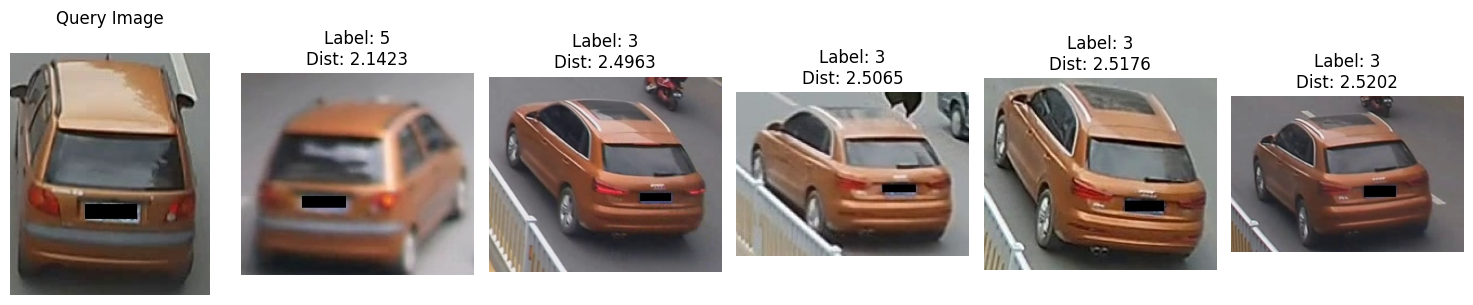

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_results(query_img_path, neighbor_img_paths, distances, labels, figsize=(15, 3)):

    num_neighbors = len(neighbor_img_paths)
    plt.figure(figsize=figsize)
    
    plt.subplot(1, num_neighbors + 1, 1)
    img = mpimg.imread(query_img_path)
    plt.imshow(img)
    plt.title("Query Image\n")
    plt.axis('off')
    
    for i, (path, dist, label) in enumerate(zip(neighbor_img_paths, distances, labels)):
        plt.subplot(1, num_neighbors + 1, i + 2)
        try:
            img = mpimg.imread(path)
            plt.imshow(img)
            plt.title(f"Label: {label}\nDist: {dist:.4f}")
            plt.axis('off')
        except FileNotFoundError:
            plt.title(f"Image not found\n{path}")
    
    plt.tight_layout()
    plt.show()


display_results(df_val['path'][18], res_query[2], res_query[0], res_query[1], figsize=(15, 3))

In [ ]:
утечка данных
метрики по классам
dino backbone
классификаторы не метрические

vehicle id, cars196 for mbr